In [ ]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ISR Dataset/IMDB Dataset.csv')

data['review'] = data['review'].str.lower()

In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because",
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [ ]:
def remove_stopwords(data):
  data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

data_without_stopwords = remove_stopwords(data)
data_without_stopwords['clean_review']= data_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['clean_review'] = data_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')


In [ ]:
reviews_list = []
for i in range(len(data['review'])):
  reviews_list.append(data['review'][i])
  sentiment = data_without_stopwords['sentiment']

In [ ]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiment)))

X_train, X_test,Y_train, Y_test = train_test_split(reviews_list, y, test_size=0.2, random_state = 45)


In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [ ]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/ISR Dataset/glove.6B.50d.txt')

maxLen = 150

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)


In [ ]:
from keras.layers import Bidirectional

In [ ]:
#model=imdb_rating(input_shape)
def imdb_rating(input_shape):

  X_indices = Input(input_shape)

  embeddings = embedding_layer(X_indices)

  X =Bidirectional(LSTM(128, return_sequences=True))(embeddings)

  X = Dropout(0.3)(X)

  X = Bidirectional(LSTM(128))(X)

  X = Dropout(0.3)(X)

  #X = LSTM(128)(X)
  #X = Dense(64)
  #X = Dropout(0.3)

  X = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=X_indices, outputs=X)

  return model

In [ ]:
model_test = imdb_rating((maxLen,))
model_test.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           5612100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 256)          183296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257 

In [ ]:
model_test.load_weights('/content/drive/MyDrive/ISR Dataset/imdb_weights_Glove_Newimproved_Bilstm.hdf5')

In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/ISR Dataset/unlabeledTrainData.tsv',error_bad_lines=False, sep='\t')

data_test

b'Skipping line 43043: expected 2 fields, saw 3\n'


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."
...,...,...
49993,18984_0,The original Man Eater by Joe D'Amato is somew...
49994,16433_0,When Home Box Office was in it's early days mo...
49995,16006_0,Griffin Dunne was born into a cultural family....
49996,40155_0,"Not a bad story, but the low budget rears its ..."


In [ ]:
data_test['review']=data_test['review'].str.lower()

In [ ]:
def remove_stopwords(data):
  data_test['review without stopwords'] = data_test['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data_test

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result

data_test_without_stopwords = remove_stopwords(data)
data_test_without_stopwords['clean_review']= data_test_without_stopwords['review without stopwords'].apply(lambda cw : remove_tags(cw))
data_test_without_stopwords['clean_review'] = data_test_without_stopwords['clean_review'].str.replace('[{}]'.format(string.punctuation), ' ')


In [ ]:
data_test_without_stopwords

,id,review,review without stopwords,clean_review
0,9999_0,"watching time chasers, it obvious that it was ...","watching time chasers, obvious made bunch frie...",watching time chasers obvious made bunch frie...
1,45057_0,i saw this film about 20 years ago and remembe...,saw film 20 years ago remember particularly na...,saw film 20 years ago remember particularly na...
2,15561_0,"minor spoilers<br /><br />in new york, joan ba...","minor spoilers<br /><br />in new york, joan ba...",minor spoilersin new york joan barnard elvir...
3,7161_0,i went to see this film with a great deal of e...,went see film great deal excitement school dir...,went see film great deal excitement school dir...
4,43971_0,"yes, i agree with everyone on this site this m...","yes, agree everyone site movie bad. even call ...",yes agree everyone site movie bad even call ...
...,...,...,...,...
49993,18984_0,the original man eater by joe d'amato is somew...,original man eater joe d'amato somewhat cult c...,original man eater joe d amato somewhat cult c...
49994,16433_0,when home box office was in it's early days mo...,home box office early days movies like one & o...,home box office early days movies like one o...
49995,16006_0,griffin dunne was born into a cultural family....,griffin dunne born cultural family. father pla...,griffin dunne born cultural family father pla...
49996,40155_0,"not a bad story, but the low budget rears its ...","not bad story, low budget rears ugly head time...",not bad story low budget rears ugly head time...


In [ ]:
test_data=data_test_without_stopwords

In [ ]:
test_data

,id,review,review without stopwords,clean_review
0,9999_0,"watching time chasers, it obvious that it was ...","watching time chasers, obvious made bunch frie...",watching time chasers obvious made bunch frie...
1,45057_0,i saw this film about 20 years ago and remembe...,saw film 20 years ago remember particularly na...,saw film 20 years ago remember particularly na...
2,15561_0,"minor spoilers<br /><br />in new york, joan ba...","minor spoilers<br /><br />in new york, joan ba...",minor spoilersin new york joan barnard elvir...
3,7161_0,i went to see this film with a great deal of e...,went see film great deal excitement school dir...,went see film great deal excitement school dir...
4,43971_0,"yes, i agree with everyone on this site this m...","yes, agree everyone site movie bad. even call ...",yes agree everyone site movie bad even call ...
...,...,...,...,...
49993,18984_0,the original man eater by joe d'amato is somew...,original man eater joe d'amato somewhat cult c...,original man eater joe d amato somewhat cult c...
49994,16433_0,when home box office was in it's early days mo...,home box office early days movies like one & o...,home box office early days movies like one o...
49995,16006_0,griffin dunne was born into a cultural family....,griffin dunne born cultural family. father pla...,griffin dunne born cultural family father pla...
49996,40155_0,"not a bad story, but the low budget rears its ...","not bad story, low budget rears ugly head time...",not bad story low budget rears ugly head time...


In [ ]:
test_data.drop("id",axis=1)

,review,review without stopwords,clean_review
0,"watching time chasers, it obvious that it was ...","watching time chasers, obvious made bunch frie...",watching time chasers obvious made bunch frie...
1,i saw this film about 20 years ago and remembe...,saw film 20 years ago remember particularly na...,saw film 20 years ago remember particularly na...
2,"minor spoilers<br /><br />in new york, joan ba...","minor spoilers<br /><br />in new york, joan ba...",minor spoilersin new york joan barnard elvir...
3,i went to see this film with a great deal of e...,went see film great deal excitement school dir...,went see film great deal excitement school dir...
4,"yes, i agree with everyone on this site this m...","yes, agree everyone site movie bad. even call ...",yes agree everyone site movie bad even call ...
...,...,...,...
49993,the original man eater by joe d'amato is somew...,original man eater joe d'amato somewhat cult c...,original man eater joe d amato somewhat cult c...
49994,when home box office was in it's early days mo...,home box office early days movies like one & o...,home box office early days movies like one o...
49995,griffin dunne was born into a cultural family....,griffin dunne born cultural family. father pla...,griffin dunne born cultural family father pla...
49996,"not a bad story, but the low budget rears its ...","not bad story, low budget rears ugly head time...",not bad story low budget rears ugly head time...


In [ ]:
reviews_test_list = []
for i in range(len(data_test['review'])):
  reviews_test_list.append(data_test['review'][i])

In [ ]:
test_data=reviews_test_list

In [ ]:
test_data

['watching time chasers, it obvious that it was made by a bunch of friends. maybe they were sitting around one day in film school and said, \\hey, let\'s pool our money together and make a really bad movie!\\" or something like that. what ever they said, they still ended up making a really bad movie--dull story, bad script, lame acting, poor cinematography, bottom of the barrel stock music, etc. all corners were cut, except the one that would have prevented this film\'s release. life\'s like that."',
 "i saw this film about 20 years ago and remember it as being particularly nasty. i believe it is based on a true incident: a young man breaks into a nurses' home and rapes, tortures and kills various women.<br /><br />it is in black and white but saves the colour for one shocking shot.<br /><br />at the end the film seems to be trying to make some political statement but it just comes across as confused and obscene.<br /><br />avoid.",
 "minor spoilers<br /><br />in new york, joan barnard

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(test_data)

words_to_index = tokenizer.word_index

In [ ]:
adam = keras.optimizers.Adam(learning_rate = 0.001)
model_test.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
X_test_indices = tokenizer.texts_to_sequences(test_data)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [ ]:
X_test_indices.shape

(49998, 150)

In [ ]:
preds=model_test.predict(X_test_indices,batch_size=128,verbose=0)

In [ ]:
n = np.random.randint(0,9999)

X_test[n]


'alan alda plays real-life "sports illustrated" writer george plimpton, who was once invited to join the detroit lions football team as an honorary member. rather wan, uncompelling drama curiously tempered with fantasy. director alex march takes an interesting tack on this material, shooting it in a quasi-documentary fashion (with macho commentary) and yet giving the tale a touch of capraesque whimsy; still, by bringing out the cinematic flashiness in this set-up, he turns the main narrative into a jumble. alda\'s smug, uncharismatic performance is another handicap, though the supporting cast is filled with real-life pro-athletes (and scintillating lauren hutton as alda\'s girlfriend--how\'s that for a fantasy?). *1/2 from ****'

In [ ]:
if preds[n] > 0.5:
  print('predicted sentiment : positive')
else:
  print('precicted sentiment : negative')




predicted sentiment : positive


In [ ]:
preds[n]

array([0.5239003], dtype=float32)

In [ ]:
reviews_list_idx = tokenizer.texts_to_sequences(reviews_test_list)

In [ ]:
def add_score_predictions(data_test, reviews_list_idx):

  data_test['sentiment score'] = 0

  reviews_list_idx = pad_sequences(reviews_list_idx, maxlen=maxLen, padding='post')

  review_preds = model_test.predict(reviews_list_idx)

  data_test['sentiment score'] = review_preds

  pred_sentiment = np.array(list(map(lambda x : 'positive' if x > 0.5 else 'negative',review_preds)))

  data_test['predicted sentiment'] = 0

  data_test['predicted sentiment'] = pred_sentiment

  return data_test



In [ ]:
data_tested= add_score_predictions(data_test, reviews_list_idx)

In [ ]:
data_tested

,id,review,review without stopwords,clean_review,sentiment score,predicted sentiment
0,9999_0,"watching time chasers, it obvious that it was ...","watching time chasers, obvious made bunch frie...",watching time chasers obvious made bunch frie...,0.018109,negative
1,45057_0,i saw this film about 20 years ago and remembe...,saw film 20 years ago remember particularly na...,saw film 20 years ago remember particularly na...,0.901900,positive
2,15561_0,"minor spoilers<br /><br />in new york, joan ba...","minor spoilers<br /><br />in new york, joan ba...",minor spoilersin new york joan barnard elvir...,0.813199,positive
3,7161_0,i went to see this film with a great deal of e...,went see film great deal excitement school dir...,went see film great deal excitement school dir...,0.028399,negative
4,43971_0,"yes, i agree with everyone on this site this m...","yes, agree everyone site movie bad. even call ...",yes agree everyone site movie bad even call ...,0.057029,negative
...,...,...,...,...,...,...
49993,18984_0,the original man eater by joe d'amato is somew...,original man eater joe d'amato somewhat cult c...,original man eater joe d amato somewhat cult c...,0.259024,negative
49994,16433_0,when home box office was in it's early days mo...,home box office early days movies like one & o...,home box office early days movies like one o...,0.029607,negative
49995,16006_0,griffin dunne was born into a cultural family....,griffin dunne born cultural family. father pla...,griffin dunne born cultural family father pla...,0.432766,negative
49996,40155_0,"not a bad story, but the low budget rears its ...","not bad story, low budget rears ugly head time...",not bad story low budget rears ugly head time...,0.146349,negative


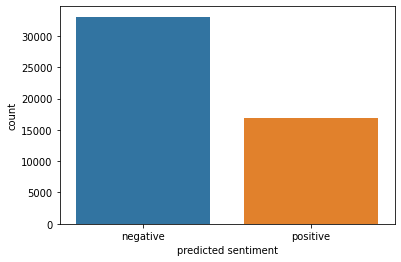

In [ ]:
import seaborn as sns
sns.countplot(x='predicted sentiment',data=data_tested)

In [ ]:
# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
#word cloud

In [ ]:
final_result=data_tested['clean_review']

In [ ]:
for i in data_tested.clean_review:
  final_result=i

In [ ]:
final_result

'not very good mummy alien flick feature cornucopia favorite movie stars like ben murphy  \\riding death\\     bob random  \\ village giants\\     darwin joston  napolean \\ assault precinct 13\\     austin stoker  bishop \\ assault precinct 13\\    dr  ken melrose  nina axelrod  \\ motel hell\\    shari belafonte harper  who voice \\ rick moranis gravedale high\\       clint young  \\ rape squad\\   \\ switchblade sisters\\    best all  pathmark pitchman james karen  \\ poltergiest\\   \\ return living dead\\   the plot this  priceless sarcophagus recovered king tut s tomb  course  taken small college california bumbling students can manhandle screw x raying it  instead of  oh  say  museum  one loathsome  video game loving student steals diamond type thingees sarcophagus  sending mummy poorly planned killing spree get back  reason  no one can catch glimpse slow moving  glowing mummy lumbers killing killing college campus this movie isn t good  not much happenens  except funny scenes t

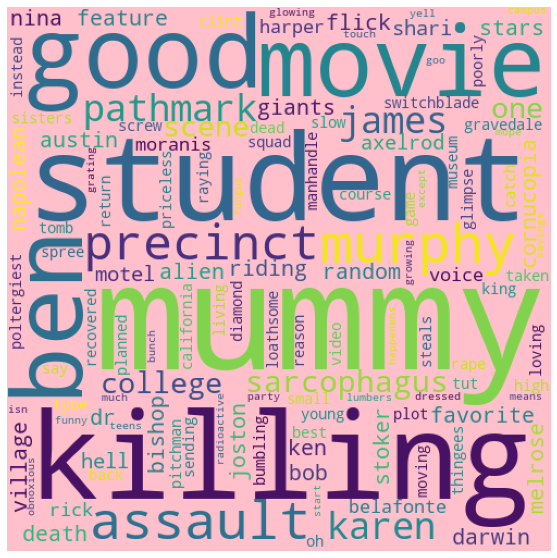

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off");
wordcloud = WordCloud(width = 500, height = 500, background_color='pink', random_state=10).generate(final_result)
plot_cloud(wordcloud)

In [ ]:
positve_review=data_tested[data_tested['predicted sentiment']=="positive"]

In [ ]:
positve_review

,id,review,review without stopwords,clean_review,sentiment score,predicted sentiment
1,45057_0,i saw this film about 20 years ago and remembe...,saw film 20 years ago remember particularly na...,saw film 20 years ago remember particularly na...,0.901900,positive
2,15561_0,"minor spoilers<br /><br />in new york, joan ba...","minor spoilers<br /><br />in new york, joan ba...",minor spoilersin new york joan barnard elvir...,0.813199,positive
8,316_0,"a well made, gritty science fiction movie, it ...","well made, gritty science fiction movie, lost ...",well made gritty science fiction movie lost ...,0.897005,positive
13,15073_0,this is quite an underrated hitchcock movie. w...,quite underrated hitchcock movie. not one best...,quite underrated hitchcock movie not one best...,0.952042,positive
15,38735_0,for the most part the acting was poorly done (...,part acting poorly done (especially part park ...,part acting poorly done especially part park ...,0.879973,positive
...,...,...,...,...,...,...
49987,35740_0,"oh joy,, another foreign torture/bloody movie ...","oh joy,, another foreign torture/bloody movie ...",oh joy another foreign torture bloody movie ...,0.601824,positive
49989,7432_0,http://eattheblinds.blogspot.com/<br /><br />i...,http://eattheblinds.blogspot.com/<br /><br />i...,http eattheblinds blogspot com if ever cross...,0.592243,positive
49990,35236_0,taste the blood of dracula marks a first for h...,taste blood dracula marks first h.g. lewis. ac...,taste blood dracula marks first h g lewis ac...,0.500502,positive
49991,12075_0,there were some aspects of this movie i really...,aspects movie really enjoyed. cinematography e...,aspects movie really enjoyed cinematography e...,0.586712,positive


In [ ]:
negative_review=data_tested[data_tested['predicted sentiment']=="negative"]

In [ ]:
negative_review

,id,review,review without stopwords,clean_review,sentiment score,predicted sentiment
0,9999_0,"watching time chasers, it obvious that it was ...","watching time chasers, obvious made bunch frie...",watching time chasers obvious made bunch frie...,0.018109,negative
3,7161_0,i went to see this film with a great deal of e...,went see film great deal excitement school dir...,went see film great deal excitement school dir...,0.028399,negative
4,43971_0,"yes, i agree with everyone on this site this m...","yes, agree everyone site movie bad. even call ...",yes agree everyone site movie bad even call ...,0.057029,negative
5,36495_0,jennifer ehle was sparkling in \pride and prej...,"jennifer ehle sparkling \pride prejudice.\"" je...",jennifer ehle sparkling \pride prejudice \ je...,0.009993,negative
6,49472_0,amy poehler is a terrific comedian on saturday...,amy poehler terrific comedian saturday night l...,amy poehler terrific comedian saturday night l...,0.086094,negative
...,...,...,...,...,...,...
49993,18984_0,the original man eater by joe d'amato is somew...,original man eater joe d'amato somewhat cult c...,original man eater joe d amato somewhat cult c...,0.259024,negative
49994,16433_0,when home box office was in it's early days mo...,home box office early days movies like one & o...,home box office early days movies like one o...,0.029607,negative
49995,16006_0,griffin dunne was born into a cultural family....,griffin dunne born cultural family. father pla...,griffin dunne born cultural family father pla...,0.432766,negative
49996,40155_0,"not a bad story, but the low budget rears its ...","not bad story, low budget rears ugly head time...",not bad story low budget rears ugly head time...,0.146349,negative


In [ ]:
positive_result=positve_review['clean_review']

In [ ]:
for i in positve_review.clean_review:
  positive_result=i

In [ ]:
positive_result

'look  don t know people eddie murphy films  they always seem get low rating imdb  watch funny  jogliore united states wrong you  wife kids watched movie loved it  loved it  funny  makes laugh  acting good enough type movie  family comedy   not godfather  anyway  really enjoyed movie just like enjoy eddie murphy s movies  have sense humour guys  come   deserves much better  7 10 mark a '

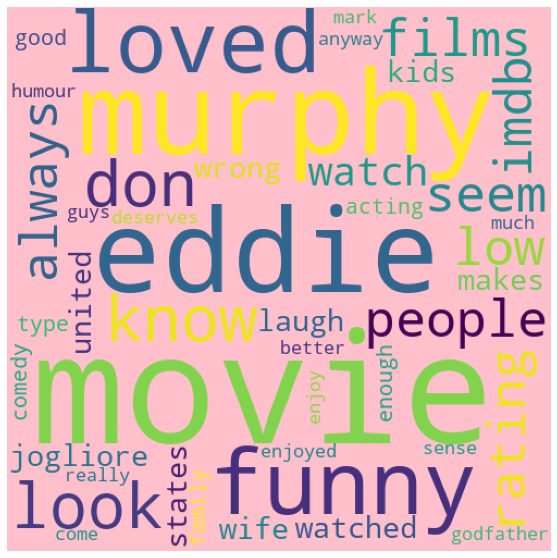

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off");
wordcloud = WordCloud(width = 500, height = 500, background_color='pink', random_state=10).generate(positive_result)
plot_cloud(wordcloud)

In [ ]:
negative_result=negative_review['clean_review']

In [ ]:
for i in negative_review.clean_review:
  negative_result=i

In [ ]:
negative_result

'not very good mummy alien flick feature cornucopia favorite movie stars like ben murphy  \\riding death\\     bob random  \\ village giants\\     darwin joston  napolean \\ assault precinct 13\\     austin stoker  bishop \\ assault precinct 13\\    dr  ken melrose  nina axelrod  \\ motel hell\\    shari belafonte harper  who voice \\ rick moranis gravedale high\\       clint young  \\ rape squad\\   \\ switchblade sisters\\    best all  pathmark pitchman james karen  \\ poltergiest\\   \\ return living dead\\   the plot this  priceless sarcophagus recovered king tut s tomb  course  taken small college california bumbling students can manhandle screw x raying it  instead of  oh  say  museum  one loathsome  video game loving student steals diamond type thingees sarcophagus  sending mummy poorly planned killing spree get back  reason  no one can catch glimpse slow moving  glowing mummy lumbers killing killing college campus this movie isn t good  not much happenens  except funny scenes t

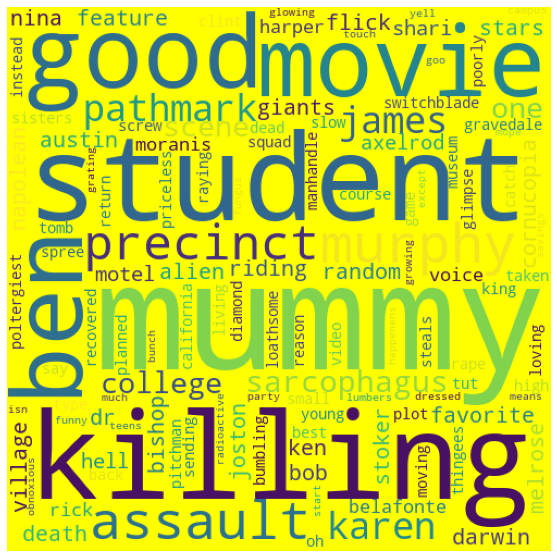

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off");
wordcloud = WordCloud(width = 500, height = 500, background_color='yellow', random_state=10).generate(negative_result)
plot_cloud(wordcloud)

In [ ]:
review_data=data_tested

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [ ]:
review_data['review_lenght'] = np.array(list(map(len, data_tested.clean_review)))
median = review_data['review_lenght'].median()
mean = review_data['review_lenght'].mean()
mode = review_data['review_lenght'].mode()[0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


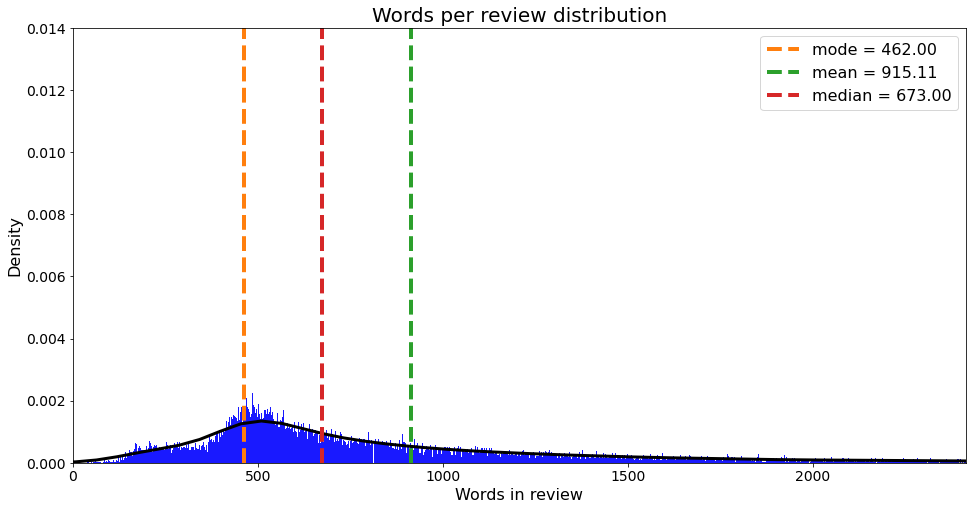

In [ ]:
fig, ax = plt.subplots()
sns.distplot(review_data['review_lenght'], bins=review_data['review_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(review_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()